In [1]:
import xarray as xr
import os
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy import stats 
from scipy.interpolate import griddata, RectBivariateSpline
import matplotlib.pyplot as plt 
import statistics
#import seaborn as sns
from tqdm.auto import tqdm 
import operator as op
import cartopy as cart
import matplotlib.ticker as mticker
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
#from mpl_toolkits.basemap import Basemap, interp
import matplotlib.colors as colors
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import kstest, mannwhitneyu, ks_2samp
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.dates as mdates
import cartopy
import cartopy.feature as cfeature

In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_closest_station(coordinates):
    
    nearest = min(stations_coordinates, key=lambda x: haversine(x[1], x[0], coordinates[1], coordinates[0]))
    return nearest

In [3]:
size = (15, 15)
longdis = 15
latdis = 15
resolution = '10m'

# Map generation Code
def generateMap(central_longitude=0):
    
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.coastlines()
    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator((range(-180, 180, longdis)))
    gl.ylocator = mticker.FixedLocator((range(-90, 90, latdis)))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.add_feature(cart.feature.BORDERS)

In [4]:
# Anomaly claculation
def standardize(x):
    return (x - x.mean())/x.std()

### Read in data (ERA5)

In [5]:
### precipitation ###

%cd ERA5/precip_dailytotal
#first re-grid on 360x180 grid with 1x1 gridcells
yearly_precip_regridded = xr.open_dataset('precip_daily_total_1979-2019_regrid.nc', engine='netcdf4')
#yearly_precip_regridded

D:\RainHeatData\ERA5\precip_dailytotal


In [6]:
#convert ERA5 precipitation to mm
yearly_precip_regridded = yearly_precip_regridded.tp*1000

In [7]:
%cd ..
%cd humid_heat\regridded_daymeans

D:\RainHeatData\ERA5
D:\RainHeatData\ERA5\humid_heat\regridded_daymeans


In [8]:
### wet bulb temperature ###

all_tw_regridded = xr.open_dataset('TW_daily_max_1979-2020_daymean_regridded.nc', engine='netcdf4')
#all_tw_regridded

In [9]:
%cd ..
%cd ..
%cd ..
daily_precip_regrid = xr.open_dataset('NOAA_CPC/precip_daily_total_1979-2022_regrid.nc', engine='netcdf4')
#daily_precip_regrid

D:\RainHeatData\ERA5\humid_heat
D:\RainHeatData\ERA5
D:\RainHeatData


In [10]:
#%cd RainHeatData
%cd ERA5/2mtemp_dailymean/processed

D:\RainHeatData\ERA5\2mtemp_dailymean\processed


In [11]:
#2mtemp_dailymax from ERA5
temp_dailymean = xr.open_dataset('2mtemp_dailymean_1979-2019_regridded.nc', engine='netcdf4')
#temp_dailymean

In [12]:
%cd ..
%cd ..
vv = xr.open_dataset('vertical_velocity_500hPa_1979-2023_regridded.nc',engine='netcdf4')

D:\RainHeatData\ERA5\2mtemp_dailymean
D:\RainHeatData\ERA5


In [13]:
#soil moisture
soil = xr.open_dataset('swv_dailymean_1979-2021_regridded.nc',engine='netcdf4')

In [14]:
vv

<xarray.Dataset>
Dimensions:  (time: 16436, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    w        (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    history:      Fri May 24 11:56:36 2024: cdo remapbil,grid_info.txt vertic...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [15]:
### section off hemispheres ###

#Northern Hemisphere - NOAA
#noaalats = np.argwhere((daily_precip_regrid.lat.values >= 0) & (daily_precip_regrid.lat.values <= 90))
#noaalons = np.argwhere((daily_precip_regrid.lon.values >= 0) & (daily_precip_regrid.lon.values <= 360))
#noaaprecip_data = daily_precip_regrid.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
#temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(0,90))
#wind_data = soil.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere - NOAA
#noaalats = np.argwhere((daily_precip_regrid.lat.values >= -90) & (daily_precip_regrid.lat.values <= 0))
#noaalons = np.argwhere((daily_precip_regrid.lon.values >= 0) & (daily_precip_regrid.lon.values <= 360))
#noaaprecip_data = daily_precip_regrid.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))

#ERA5 Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(0,90))
wind_data = vv.sel(lon = slice(0,360), lat=slice(0,90))

#ERA5 Southern Hemisphere 
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))
#temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(-90,0))
#wind_data = vv.sel(lon = slice(0,360), lat=slice(-90,0))

In [17]:
#cut TW time so data are the same
TW_data = TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
#ERA5
precip_data = precip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
#NOAA
#precip_data = noaaprecip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
temp_data = temp_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
wind_data = wind_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

#select JJA months - summer for North Hem
#NOAA
#precip_data_JJA = noaaprecip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True).precip
#ERA5
precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([6,7,8]),drop=True).TW
temp_data_JJA = temp_data.where(temp_data.time.dt.month.isin([6,7,8]),drop=True).t2m 
wind_data_JJA = wind_data.where(temp_data.time.dt.month.isin([6,7,8]),drop=True).w

#select DJF months - summer for Southern Hem
# era5 precip
#precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([12,1,2]),drop=True) #tp for ERA5
#TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([12,1,2]),drop=True).TW
#temp_data_JJA = temp_data.where(temp_data.time.dt.month.isin([12,1,2]),drop=True).t2m 
#wind_data_JJA = wind_data.where(temp_data.time.dt.month.isin([12,1,2]),drop=True).w
#noaa precip
#precip_data_JJA = noaaprecip_data.where(precip_data.time.dt.month.isin([12,1,2]),drop=True).precip

In [19]:
#daily average
precip_mean = precip_data_JJA.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = precip_data_JJA.rolling(time = 30, center = True).mean('time')

#anomaly
precip_data_anom = precip_data_JJA.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time') #or .tp for ERA5 precip
#precip_data_anom = precip_data_JJA.groupby('time.dayofyear') - precip_mean

In [20]:
#daily average
TW_mean = TW_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = TW_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')
#TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_mean

In [21]:
#daily average
temp_mean = temp_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
temp_rolling = temp_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
temp_data_anom = temp_data_JJA.groupby('time.dayofyear') - temp_rolling.groupby('time.dayofyear').mean(dim='time')
#TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_mean

In [22]:
#wind daily average
wind_mean = wind_data_JJA.groupby('time.dayofyear').mean(dim='time')
wind_rolling = wind_data_JJA.rolling(time = 30, center = True).mean('time')
wind_data_anom = wind_data_JJA.groupby('time.dayofyear') - wind_rolling.groupby('time.dayofyear').mean(dim='time')

In [23]:
#percentile thresholds for anomalies
percentile_cutoff_JJA = np.nanpercentile(precip_data_anom, q=90, axis=0)
percentile_cutoff_TW_JJA = np.nanpercentile(TW_data_anom, q=90, axis=0)
percentile_cutoff_temp_JJA = np.nanpercentile(temp_data_anom, q=90, axis=0)
percentile_cutoff_wind_JJA = np.nanpercentile(wind_data_anom, q=90, axis=0)

In [24]:
#### Percentile thresholds for raw data ####

#percentile of wet days >1 mm 
raw_percentile_cutoff_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
raw_percentile_cutoff_TW_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
raw_percentile_cutoff_temp_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
raw_percentile_cutoff_wind_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))

rain_threshold = 1
for i in range(precip_data_JJA.shape[1]):
    
    for j in range(precip_data_JJA.shape[2]):
        
        precip_data_for_coordinate = precip_data_JJA[:,i,j]
        TW_data_for_coordinate = TW_data_JJA[:,j,i]
        temp_data_for_coordinate = temp_data_JJA[:,i,j]
        wind_data_for_coordinate = wind_data_JJA[:,i,j]
        
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        
        precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        TW_data_JJA_pc = TW_data_for_coordinate
        temp_data_JJA_pc = temp_data_for_coordinate
        wind_data_JJA_pc = wind_data_for_coordinate
        
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)
        raw_percentile_cutoff_TW_JJA[i][j] = np.nanpercentile(TW_data_JJA_pc, q=90)
        raw_percentile_cutoff_temp_JJA[i][j] = np.nanpercentile(temp_data_JJA_pc, q=90)
        raw_percentile_cutoff_wind_JJA[i][j] = np.nanpercentile(wind_data_JJA_pc, q=90)

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Make Difference Maps 

In [23]:
#OFFICIAL CODE HERE

results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2])) 
#np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7)) 
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#results_JJA_median = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#median = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#mean = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#mean_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#mean_extreme_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#mean_extreme_precip_TWcond= np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#mean_extreme_precip_tempcond= np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()
#total_temp_nonextreme = list()
#total_temp_extreme = list()

### for day of ###
buffer = 0 
#for buffer in range(1, 4, 1):

for i in range(precip_data_anom.shape[1]):

    for j in range(precip_data_anom.shape[2]):

        # Iterate through every point in the US data, and calculate the difference in mean 
        TW_data_for_coordinate = TW_data_anom[:,j,i]
        #temp_data_for_coordinate = temp_data_anom[:,i,j]
        precip_data_for_coordinate = precip_data_anom[:,i,j]
        wind_data_for_coordinate = wind_data_anom[:,i,j]
        
        ### 3 DAYS BEFORE / 3 DAYS AFTER ###
        #buffers (-3,0,1) / (1,4,1)
        #if buffer == -3 / 1
        #for buffer in range(-3,0,1):
         #   if buffer == -3:
          #      idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate)>= percentile_cutoff_JJA[i][j])) + buffer)
           #     idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
           #     idx_temp = np.squeeze((np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer)
            #else:
             #   idx = np.append(idx,(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate)>= percentile_cutoff_JJA[i][j])) + buffer))
              #  idx_TW = np.append(idx_TW, (np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer))
              #  idx_temp = np.append(idx_temp, (np.squeeze(np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer))
                #idx = np.append(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer) #stacks into 1 list of all days before event
         
        ### DAY OF ###
        #for buffer == 0:
        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)
        #idx_temp = np.squeeze(np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer

        idx = idx[idx<=3771] #JJA
        idx_wind = idx_wind[idx_wind<=3771]
        #idx = idx[idx<=3689] #DJF
 
        idx_TW = idx_TW[idx_TW<=3771] #JJA
        #idx_TW = idx_TW[idx_TW<=3689] #DJF

        #idx_temp = idx_temp[idx_temp<=3771] #JJA
        #idx_temp = idx_temp[idx_temp<=3689] #DJF
        
        total_TW_nonextreme.append(TW_data_for_coordinate[~idx]) #days that aren't extreme
        total_TW_extreme.append(TW_data_for_coordinate[idx]) #days that are (in index)
        #total_temp_nonextreme.append(temp_data_for_coordinate[~idx]) #days that aren't extreme
        #total_temp_extreme.append(temp_data_for_coordinate[idx]) #days that are (in index)
        
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~idx], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j] = 1 #[buffer]
        else:
            significant_mask[i][j] = 0 #[buffer]
                
        if precip_data_for_coordinate[idx_TW].size != 0 and precip_data_for_coordinate[idx_TW].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_TW], precip_data_for_coordinate[idx_TW]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1 #[buffer]
        else:
            significant_mask_precip[i][j]= 0 #[buffer]
                
        #if precip_data_for_coordinate[idx_temp].size != 0 and precip_data_for_coordinate[idx_temp].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_temp], precip_data_for_coordinate[idx_temp]).pvalue <= 0.05:
         #   significant_mask_precip[i][j] = 1
        #else:
         #   significant_mask_precip[i][j] = 0    
                
        #if temp_data_for_coordinate[idx].size != 0 and temp_data_for_coordinate[idx].size >= 20 and ks_2samp(temp_data_for_coordinate[~idx], temp_data_for_coordinate[idx]).pvalue <= 0.05:
         #   significant_mask_temp[i][j] = 1
        #else:
         #   significant_mask_temp[i][j] = 0    
        
    #REMOVE [buffer+3]
        #mean[i][j][buffer+3] = np.mean(TW_data_for_coordinate)
        #mean[i][j][buffer+3] = np.mean(temp_data_for_coordinate)
        #mean_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate)
        #mean_extreme_precip_TWcond[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_TW])
        #mean_extreme_precip_tempcond[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_temp])
        #mean_extreme_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx])
        #median[i][j][buffer+3] = np.median(TW_data_for_coordinate)
        #median[i][j][buffer+3] = np.median(temp_data_for_coordinate)
        
        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~idx])
        #results_JJA[i][j] = np.mean(temp_data_for_coordinate[idx]) - np.mean(temp_data_for_coordinate[~idx])
        results_JJA_precip[i][j]= np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])
        #results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_temp]) - np.mean(precip_data_for_coordinate[~idx_temp])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx]) - np.mean(wind_data_for_coordinate[~idx])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~idx_TW])
        #results_JJA_median[i][j][buffer+3] = (np.median(TW_data_for_coordinate[idx]) - np.median(TW_data_for_coordinate[~idx])) #/ np.median(TW_data_for_coordinate[~idx])
        #results_JJA_median[i][j][buffer+3] = (np.median(temp_data_for_coordinate[idx]) - np.median(temp_data_for_coordinate[~idx]))           

In [25]:
### EDITED TO ONLY INCLUDE SINGLE EXTREME TW DAYS - NOT OVERLAPPING ###

results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2])) 
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()

### for day of ###
buffer = 0 

for i in range(precip_data_anom.shape[1]):

    for j in range(precip_data_anom.shape[2]):

        # Iterate through every point in the US data, and calculate the difference in mean 
        TW_data_for_coordinate = TW_data_anom[:,j,i]
        #temp_data_for_coordinate = temp_data_anom[:,i,j]
        precip_data_for_coordinate = precip_data_anom[:,i,j]
        wind_data_for_coordinate = wind_data_anom[:,i,j]

        ### DAY OF ###
        #for buffer == 0:
        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)
        #idx_temp = np.squeeze(np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer

        # NEW CODE HERE: 
        #Filter out extreme days that are surrounded by other extreme days
        isolated_extreme_days = []
        for day in idx_TW:
            if day > 0 and day < len(TW_data_for_coordinate) - 1:
                if day-1 not in idx_TW and day+1 not in idx_TW:
                    isolated_extreme_days.append(day)
            elif day == 0 and day+1 not in idx_TW:
                isolated_extreme_days.append(day)
            elif day == len(TW_data_for_coordinate) - 1 and day-1 not in idx_TW:
                isolated_extreme_days.append(day)
        
        idx_TW = np.array(isolated_extreme_days)
        # END NEW CODE SECTION #

        
        idx = idx[idx<=3771] #JJA
        idx_wind = idx_wind[idx_wind<=3771]
        idx_TW = idx_TW[idx_TW<=3771] #JJA

        #NEW CODE HERE
        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW)])
        total_TW_extreme.append(TW_data_for_coordinate[idx]) #days that are (in index)
        #total_temp_nonextreme.append(temp_data_for_coordinate[~idx]) #days that aren't extreme
        #total_temp_extreme.append(temp_data_for_coordinate[idx]) #days that are (in index)
        
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~idx], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j] = 1 #[buffer]
        else:
            significant_mask[i][j] = 0 #[buffer]
                
        if precip_data_for_coordinate[idx_TW].size != 0 and precip_data_for_coordinate[idx_TW].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_TW], precip_data_for_coordinate[idx_TW]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1 #[buffer]
        else:
            significant_mask_precip[i][j]= 0 #[buffer]
                
       
        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~idx])
        results_JJA_precip[i][j]= np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx]) - np.mean(wind_data_for_coordinate[~idx])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~idx_TW])  

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [42]:
### EDITED TO ONLY INCLUDE SINGLE EXTREME PRECIP DAYS - NOT OVERLAPPING ###

results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2])) 
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()

### for day of ###
buffer = 0 

for i in range(precip_data_anom.shape[1]):

    for j in range(precip_data_anom.shape[2]):

        # Iterate through every point in the US data, and calculate the difference in mean 
        TW_data_for_coordinate = TW_data_anom[:,j,i]
        #temp_data_for_coordinate = temp_data_anom[:,i,j]
        precip_data_for_coordinate = precip_data_anom[:,i,j]
        wind_data_for_coordinate = wind_data_anom[:,i,j]

        ### DAY OF ###
        #for buffer == 0:
        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)
        #idx_temp = np.squeeze(np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer

        # NEW CODE HERE: 
        #Filter out extreme days that are surrounded by other extreme days
        isolated_extreme_days = []
        for day in idx:
            if day > 0 and day < len(precip_data_for_coordinate) - 1:
                if day-1 not in idx and day+1 not in idx:
                    isolated_extreme_days.append(day)
            elif day == 0 and day+1 not in idx:
                isolated_extreme_days.append(day)
            elif day == len(precip_data_for_coordinate) - 1 and day-1 not in idx:
                isolated_extreme_days.append(day)
        
        idx = np.array(isolated_extreme_days)
        # END NEW CODE SECTION #

        
        idx = idx[idx<=3771] #JJA
        idx_wind = idx_wind[idx_wind<=3771]
        idx_TW = idx_TW[idx_TW<=3771] #JJA

        #NEW CODE HERE
        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW)])
        total_TW_extreme.append(TW_data_for_coordinate[idx]) #days that are (in index)
        #total_temp_nonextreme.append(temp_data_for_coordinate[~idx]) #days that aren't extreme
        #total_temp_extreme.append(temp_data_for_coordinate[idx]) #days that are (in index)
        
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~idx], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j] = 1 #[buffer]
        else:
            significant_mask[i][j] = 0 #[buffer]
                
        if precip_data_for_coordinate[idx_TW].size != 0 and precip_data_for_coordinate[idx_TW].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_TW], precip_data_for_coordinate[idx_TW]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1 #[buffer]
        else:
            significant_mask_precip[i][j]= 0 #[buffer]
                
       
        #results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~idx])
        #results_JJA_precip[i][j]= np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])
        #results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx]) - np.mean(wind_data_for_coordinate[~idx])
        #results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~idx_TW]) 
        
        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx)])
        results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_TW)])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW)])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW)])

In [24]:
### SECOND EDIT NO OVERLAP FOR PRECIP EXTREMES EITHER

import numpy as np

def get_isolated_extremes(data, percentile_cutoff):
    # Identify extreme days
    idx_extreme = np.squeeze(np.argwhere(np.array(data) >= percentile_cutoff))
    
    # Filter out extreme days that are surrounded by other extreme days
    isolated_extreme_days = []
    for day in idx_extreme:
        if day > 0 and day < len(data) - 1:
            if day-1 not in idx_extreme and day+1 not in idx_extreme:
                isolated_extreme_days.append(day)
        elif day == 0 and day+1 not in idx_extreme:
            isolated_extreme_days.append(day)
        elif day == len(data) - 1 and day-1 not in idx_extreme:
            isolated_extreme_days.append(day)
    
    return np.array(isolated_extreme_days)

for i in range(precip_data_anom.shape[1]):
    for j in range(precip_data_anom.shape[2]):
        TW_data_for_coordinate = TW_data_anom[:,j,i]
        precip_data_for_coordinate = precip_data_anom[:,i,j]
        wind_data_for_coordinate = wind_data_anom[:,i,j]
        
        # Identify isolated extreme TW days
        idx_TW = get_isolated_extremes(TW_data_for_coordinate, percentile_cutoff_TW_JJA[j][i])
        
        # Identify isolated extreme precipitation days
        idx = get_isolated_extremes(precip_data_for_coordinate, percentile_cutoff_JJA[i][j])
        
        # Identify extreme wind days (unchanged)
        idx_wind = np.squeeze(np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j]))

        # Apply JJA limit
        idx = idx[idx<=3771]
        idx_wind = idx_wind[idx_wind<=3771]
        idx_TW = idx_TW[idx_TW<=3771]
        
        # Append to total lists
        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW)])
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW])
        
        # Calculate statistics and significance
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx)], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j] = 1
        else:
            significant_mask[i][j] = 0
                
        if precip_data_for_coordinate[idx_TW].size != 0 and precip_data_for_coordinate[idx_TW].size >= 20 and ks_2samp(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_TW)], precip_data_for_coordinate[idx_TW]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1
        else:
            significant_mask_precip[i][j] = 0
        
        # Calculate results
        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx)])
        results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_TW)])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx)])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW)])

NameError: name 'total_TW_nonextreme' is not defined

In [25]:
#Isolated idx and idx_TW

results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()

# Array to store the number of one-day extreme events at each grid cell
#num_extreme_events_TW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

buffer = 0

for i in range(precip_data_anom.shape[1]):
    for j in range(precip_data_anom.shape[2]):
        TW_data_for_coordinate = TW_data_anom[:, j, i]
        precip_data_for_coordinate = precip_data_anom[:, i, j]
        wind_data_for_coordinate = wind_data_anom[:, i, j]

        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)

        # Filter out extreme days that are surrounded by other extreme days for TW
        isolated_extreme_days_TW = []
        for day in idx_TW:
            if (day > 0) and (day < len(TW_data_for_coordinate) - 1):
                if (day-1) not in idx_TW and (day+1) not in idx_TW:
                    isolated_extreme_days_TW.append(day)
            elif (day == 0) and (day+1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
            elif (day == len(TW_data_for_coordinate) - 1) and (day-1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
        idx_TW_isolated = np.array(isolated_extreme_days_TW)

        # Filter out extreme days that are surrounded by other extreme days for precip
        isolated_extreme_days_precip = []
        for day in idx:
            if (day > 0) and (day < len(precip_data_for_coordinate) - 1):
                if (day-1) not in idx and (day+1) not in idx:
                    isolated_extreme_days_precip.append(day)
            elif (day == 0) and (day+1) not in idx:
                isolated_extreme_days_precip.append(day)
            elif (day == len(precip_data_for_coordinate) - 1) and (day-1) not in idx:
                isolated_extreme_days_precip.append(day)
        idx_isolated = np.array(isolated_extreme_days_precip)

        idx_isolated = idx_isolated[idx_isolated <= 3771]
        idx_wind = idx_wind[idx_wind <= 3771]
        idx_TW_isolated = idx_TW_isolated[idx_TW_isolated <= 3771]

        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW_isolated])

        if TW_data_for_coordinate[idx_TW_isolated].size != 0 and TW_data_for_coordinate[idx_TW_isolated].size >= 20 and ks_2samp(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)], TW_data_for_coordinate[idx_TW_isolated]).pvalue <= 0.05:
            significant_mask[i][j] = 1
        else:
            significant_mask[i][j] = 0

        if precip_data_for_coordinate[idx_isolated].size != 0 and precip_data_for_coordinate[idx_isolated].size >= 20 and ks_2samp(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)], precip_data_for_coordinate[idx_isolated]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1
        else:
            significant_mask_precip[i][j] = 0

        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx_TW_isolated]) - np.mean(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_isolated]) - np.mean(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])


In [25]:
#PERCENTAGE OF ISOLATED EXTREME DAYS OF ALL EXTREME DAYS#
results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()

# Arrays to store the percentages of isolated extremes
percentage_isolated_TW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
percentage_isolated_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

total_isolated_extreme_TW = 0
total_extreme_TW = 0
total_isolated_extreme_precip = 0
total_extreme_precip = 0

buffer = 0

for i in range(precip_data_anom.shape[1]):
    for j in range(precip_data_anom.shape[2]):
        TW_data_for_coordinate = TW_data_anom[:, j, i]
        precip_data_for_coordinate = precip_data_anom[:, i, j]
        wind_data_for_coordinate = wind_data_anom[:, i, j]

        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)

        # Filter out extreme days that are surrounded by other extreme days for TW
        isolated_extreme_days_TW = []
        for day in idx_TW:
            if (day > 0) and (day < len(TW_data_for_coordinate) - 1):
                if (day-1) not in idx_TW and (day+1) not in idx_TW:
                    isolated_extreme_days_TW.append(day)
            elif (day == 0) and (day+1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
            elif (day == len(TW_data_for_coordinate) - 1) and (day-1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
        idx_TW_isolated = np.array(isolated_extreme_days_TW)

        # Filter out extreme days that are surrounded by other extreme days for precip
        isolated_extreme_days_precip = []
        for day in idx:
            if (day > 0) and (day < len(precip_data_for_coordinate) - 1):
                if (day-1) not in idx and (day+1) not in idx:
                    isolated_extreme_days_precip.append(day)
            elif (day == 0) and (day+1) not in idx:
                isolated_extreme_days_precip.append(day)
            elif (day == len(precip_data_for_coordinate) - 1) and (day-1) not in idx:
                isolated_extreme_days_precip.append(day)
        idx_isolated = np.array(isolated_extreme_days_precip)

        idx_isolated = idx_isolated[idx_isolated <= 3771]
        idx_wind = idx_wind[idx_wind <= 3771]
        idx_TW_isolated = idx_TW_isolated[idx_TW_isolated <= 3771]

        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW_isolated])

        # Calculate percentage of isolated extremes for TW
        if len(idx_TW) > 0:
            percentage_isolated_TW[i][j] = len(idx_TW_isolated) / len(idx_TW) * 100
        else:
            percentage_isolated_TW[i][j] = 0
        
        # Calculate percentage of isolated extremes for precip
        if len(idx) > 0:
            percentage_isolated_precip[i][j] = len(idx_isolated) / len(idx) * 100
        else:
            percentage_isolated_precip[i][j] = 0

        # Accumulate total counts for TW and precip
        total_isolated_extreme_TW += len(idx_TW_isolated)
        total_extreme_TW += len(idx_TW)
        total_isolated_extreme_precip += len(idx_isolated)
        total_extreme_precip += len(idx)

        if TW_data_for_coordinate[idx_TW_isolated].size != 0 and TW_data_for_coordinate[idx_TW_isolated].size >= 20 and ks_2samp(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)], TW_data_for_coordinate[idx_TW_isolated]).pvalue <= 0.05:
            significant_mask[i][j] = 1
        else:
            significant_mask[i][j] = 0

        if precip_data_for_coordinate[idx_isolated].size != 0 and precip_data_for_coordinate[idx_isolated].size >= 20 and ks_2samp(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)], precip_data_for_coordinate[idx_isolated]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1
        else:
            significant_mask_precip[i][j] = 0

        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx_TW_isolated]) - np.mean(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_isolated]) - np.mean(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])

# Calculate total percentages of isolated extremes across the entire timeseries
total_percentage_isolated_TW = (total_isolated_extreme_TW / total_extreme_TW * 100) if total_extreme_TW > 0 else 0
total_percentage_isolated_precip = (total_isolated_extreme_precip / total_extreme_precip * 100) if total_extreme_precip > 0 else 0


In [38]:
#minimum percentage of isolated TW extremes
np.min(percentage_isolated_TW)

1.3227513227513228

In [39]:
#maximum percentage of isolated TW extremes
np.max(percentage_isolated_TW)

78.04232804232805

In [40]:
#minimum percentage of isolated precipitation extremes
np.min(percentage_isolated_precip)

0.0

In [41]:
#maximum percentage of isolated precipitation extremes
np.max(percentage_isolated_precip)

87.56613756613757

In [29]:
#COUNTS OF EXTREME DAYS
import numpy as np
from scipy.stats import ks_2samp

# num_extreme_events_TW now contains the count of one-day extreme events at each grid cell.


# Assuming precip_data_anom, TW_data_anom, wind_data_anom, 
# percentile_cutoff_JJA, percentile_cutoff_TW_JJA, and percentile_cutoff_wind_JJA 
# are predefined numpy arrays with appropriate shapes and data.

# Initialize result arrays
results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
results_JJA_wind_onTW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

total_TW_nonextreme = []
total_TW_extreme = []

# Array to store the number of one-day extreme events at each grid cell
num_extreme_events_TW = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
num_extreme_events_TW_multi = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
num_extreme_events_TW_ratio = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

num_extreme_events_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
num_extreme_events_precip_multi = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
num_extreme_events_precip_ratio = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))

buffer = 0

for i in range(precip_data_anom.shape[1]):
    for j in range(precip_data_anom.shape[2]):
        TW_data_for_coordinate = TW_data_anom[:, j, i]
        precip_data_for_coordinate = precip_data_anom[:, i, j]
        wind_data_for_coordinate = wind_data_anom[:, i, j]

        idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
        idx_TW = np.squeeze((np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer)
        idx_wind = np.squeeze((np.argwhere(np.array(wind_data_for_coordinate) >= percentile_cutoff_wind_JJA[i][j])) + buffer)

        # Filter out extreme days that are surrounded by other extreme days for TW
        isolated_extreme_days_TW = []
        for day in idx_TW:
            if (day > 0) and (day < len(TW_data_for_coordinate) - 1):
                if (day-1) not in idx_TW and (day+1) not in idx_TW:
                    isolated_extreme_days_TW.append(day)
            elif (day == 0) and (day+1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
            elif (day == len(TW_data_for_coordinate) - 1) and (day-1) not in idx_TW:
                isolated_extreme_days_TW.append(day)
        idx_TW_isolated = np.array(isolated_extreme_days_TW)

        # Filter out extreme days that are surrounded by other extreme days for precip
        isolated_extreme_days_precip = []
        for day in idx:
            if (day > 0) and (day < len(precip_data_for_coordinate) - 1):
                if (day-1) not in idx and (day+1) not in idx:
                    isolated_extreme_days_precip.append(day)
            elif (day == 0) and (day+1) not in idx:
                isolated_extreme_days_precip.append(day)
            elif (day == len(precip_data_for_coordinate) - 1) and (day-1) not in idx:
                isolated_extreme_days_precip.append(day)
        idx_isolated = np.array(isolated_extreme_days_precip)

        idx_isolated = idx_isolated[idx_isolated <= 3771]
        idx_wind = idx_wind[idx_wind <= 3771]
        idx_TW_isolated = idx_TW_isolated[idx_TW_isolated <= 3771]

        total_TW_nonextreme.append(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW_isolated])

        if TW_data_for_coordinate[idx_TW_isolated].size != 0 and TW_data_for_coordinate[idx_TW_isolated].size >= 20 and ks_2samp(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)], TW_data_for_coordinate[idx_TW_isolated]).pvalue <= 0.05:
            significant_mask[i][j] = 1
        else:
            significant_mask[i][j] = 0

        if precip_data_for_coordinate[idx_isolated].size != 0 and precip_data_for_coordinate[idx_isolated].size >= 20 and ks_2samp(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)], precip_data_for_coordinate[idx_isolated]).pvalue <= 0.05:
            significant_mask_precip[i][j] = 1
        else:
            significant_mask_precip[i][j] = 0

        results_JJA[i][j] = np.mean(TW_data_for_coordinate[idx_TW_isolated]) - np.mean(TW_data_for_coordinate[~np.isin(range(len(TW_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_isolated]) - np.mean(precip_data_for_coordinate[~np.isin(range(len(precip_data_for_coordinate)), idx_isolated)])
        results_JJA_wind[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])
        results_JJA_wind_onTW[i][j] = np.mean(wind_data_for_coordinate[idx_TW_isolated]) - np.mean(wind_data_for_coordinate[~np.isin(range(len(wind_data_for_coordinate)), idx_TW_isolated)])
        
        # Store the count of isolated extreme events for TW at each grid cell
        num_extreme_events_TW[i][j] = len(idx_TW_isolated)
        num_extreme_events_TW_multi[i][j] = len(idx_TW)
        num_extreme_events_TW_ratio[i][j] = len(idx_TW_isolated)/len(idx_TW)

        num_extreme_events_precip[i][j] = len(idx_isolated)
        num_extreme_events_precip_multi[i][j] = len(idx)
        num_extreme_events_precip_ratio[i][j] = len(idx_isolated)/len(idx)

In [40]:
#total_TW_extreme.append(TW_data_for_coordinate[idx_TW_isolated])
num_extreme_events_TW

array([[35., 26., 21., ..., 24., 31., 33.],
       [38., 42., 39., ..., 43., 29., 42.],
       [43., 50., 46., ..., 28., 33., 34.],
       ...,
       [92., 91., 89., ..., 93., 93., 95.],
       [84., 87., 84., ..., 83., 82., 83.],
       [82., 81., 83., ..., 85., 83., 82.]])

In [38]:
#Day of
day_of_JJA_precip = np.squeeze(results_JJA_precip[:,:,3])
day_of_JJA = np.squeeze(results_JJA[:,:,3])

day_of_JJA_sigmask_precip = np.squeeze(significant_mask_precip[:,:,3])
day_of_JJA_sigmask = np.squeeze(significant_mask[:,:,3])

In [30]:
#Day of
day_of_JJA_precip = np.mean(results_JJA_precip)
day_of_JJA = np.mean(results_JJA)

day_of_JJA_sigmask_precip = np.mean(significant_mask_precip)
day_of_JJA_sigmask = np.mean(significant_mask)

In [40]:
#BEFORE -- remove 3rd dimension
Before_JJA_precip = np.mean(results_JJA_precip[:,:,0:2], axis=2)
Before_JJA_TW = np.mean(results_JJA[:,:,0:2], axis=2)

Before_JJA_sigmask_TW = np.mean(significant_mask[:,:,0:2], axis=2)
Before_JJA_sigmask_precip = np.mean(significant_mask_precip[:,:,0:2], axis=2)

#AFTER -- 
After_JJA_precip = np.mean(results_JJA_precip[:,:,4:7], axis=2)
After_JJA_TW = np.mean(results_JJA[:,:,4:7], axis=2)

After_JJA_sigmask_TW = np.mean(significant_mask[:,:,4:7], axis=2)
After_JJA_sigmask_precip = np.mean(significant_mask_precip[:,:,4:7], axis=2)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [47]:
### Save JJA sigmasks ###

#BEFORE
#np.savetxt('/RainHeatData/Figures/diffmap_datasets/Before_JJA_precip.txt', Before_JJA_precip, delimiter = ',')
#np.savetxt('/RainHeatData/Figures/diffmap_datasets/Before_JJA_TW.txt', Before_JJA_TW, delimiter = ',')
#np.savetxt('/RainHeatData/Figures/diffmap_datasets/Before_JJA_sigmask_TW.txt', Before_JJA_sigmask_TW, delimiter = ',')
#np.savetxt('/RainHeatData/Figures/diffmap_datasets/Before_JJA_sigmask_precip.txt', Before_JJA_sigmask_precip, delimiter = ',')

#AFTER
np.savetxt('/RainHeatData/Figures/diffmap_datasets/After_JJA_precip.txt', After_JJA_precip, delimiter = ',')
np.savetxt('/RainHeatData/Figures/diffmap_datasets/After_JJA_TW.txt', After_JJA_TW, delimiter = ',')
np.savetxt('/RainHeatData/Figures/diffmap_datasets/After_JJA_sigmask_TW.txt', After_JJA_sigmask_TW, delimiter = ',')
np.savetxt('/RainHeatData/Figures/diffmap_datasets/After_JJA_sigmask_precip.txt', After_JJA_sigmask_precip, delimiter = ',')

## Keep truncated - revert back to -2 to 2

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


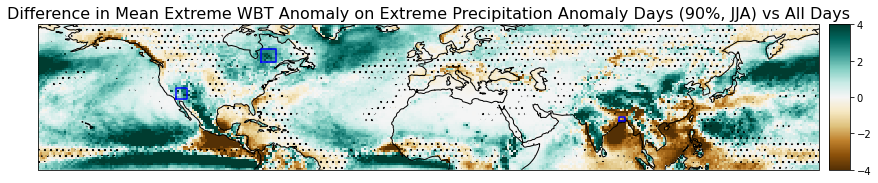

In [45]:
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))
fig= plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-180, 180, 0, 67]
#cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))

sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_precip,transform=ccrs.PlateCarree(), cmap='BrBG',vmin=-4,vmax=4) #coolwarm, BrBG
#norm=divnorm
#sm = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], np.ma.masked_equal(Before_sigmask,1), facecolor = 'None', edgecolors = None, cmap='coolwarm')
#np.ma.masked_less(day_of_JJA_sigmask_precip,0)

sm = plt.contourf(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], significant_mask_precip, 3, hatches=['..', ''], color = 'grey',linestyles = None, alpha = 0)
### test if this covers sig of non-sig values ###
#hatches=['', '..']

# Set the lat/lon limits of the inset map [x0, x1, y0, y1]
inset_extent = [87.5, 90.5, 22.5, 24.5]
inset_extent2 = [282.5, 289.5, 49.5, 55.5]
inset_extent3 = [243.5, 248.5, 32.5, 37.5]

# Add box around location of inset map on the main map
x = [inset_extent[0], inset_extent[1], inset_extent[1], inset_extent[0], inset_extent[0]]
y = [inset_extent[2], inset_extent[2], inset_extent[3], inset_extent[3], inset_extent[2]]
ax.plot(x, y,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x2 = [inset_extent2[0], inset_extent2[1], inset_extent2[1], inset_extent2[0], inset_extent2[0]]
y2 = [inset_extent2[2], inset_extent2[2], inset_extent2[3], inset_extent2[3], inset_extent2[2]]
ax.plot(x2, y2,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x3 = [inset_extent3[0], inset_extent3[1], inset_extent3[1], inset_extent3[0], inset_extent3[0]]
y3 = [inset_extent3[2], inset_extent3[2], inset_extent3[3], inset_extent3[3], inset_extent3[2]]
ax.plot(x3, y3,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Difference in Mean Extreme WBT Anomaly on Extreme Precipitation Anomaly Days (90%, JJA) vs All Days', fontsize=16)
#Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation Anomaly Days
#Difference in Mean Extreme Precipitation Anomaly on Extreme Wet Bulb Temperature Anomaly Days


plt.colorbar(sc,cax=cax) # Similar to fig.colorbar(im, cax = cax) sc, cax=cax
#, extend='both'
#plt.colorbar(sm,cax=cax)
plt.clim(-4,4)
#-2.5-2.5 for TW, -4-4 for Precip
#-5+5 for t2m, -8+8 for precip

#plt.savefig('/RainHeatData/Figs_9_2_23/tw_3daysafter_diff_Nhem_sigmask.png')
plt.show()

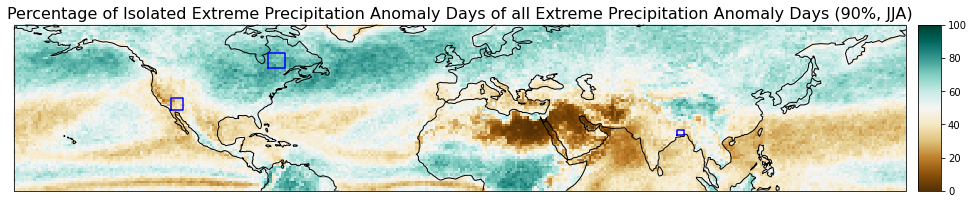

In [32]:
# number of extremes map
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))
fig= plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-180, 180, 0, 67]
#cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))

sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], percentage_isolated_precip,transform=ccrs.PlateCarree(), cmap='BrBG',vmin=0,vmax=100) #coolwarm, BrBG

# Set the lat/lon limits of the inset map [x0, x1, y0, y1]
inset_extent = [87.5, 90.5, 22.5, 24.5]
inset_extent2 = [282.5, 289.5, 49.5, 55.5]
inset_extent3 = [243.5, 248.5, 32.5, 37.5]

# Add box around location of inset map on the main map
x = [inset_extent[0], inset_extent[1], inset_extent[1], inset_extent[0], inset_extent[0]]
y = [inset_extent[2], inset_extent[2], inset_extent[3], inset_extent[3], inset_extent[2]]
ax.plot(x, y,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x2 = [inset_extent2[0], inset_extent2[1], inset_extent2[1], inset_extent2[0], inset_extent2[0]]
y2 = [inset_extent2[2], inset_extent2[2], inset_extent2[3], inset_extent2[3], inset_extent2[2]]
ax.plot(x2, y2,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x3 = [inset_extent3[0], inset_extent3[1], inset_extent3[1], inset_extent3[0], inset_extent3[0]]
y3 = [inset_extent3[2], inset_extent3[2], inset_extent3[3], inset_extent3[3], inset_extent3[2]]
ax.plot(x3, y3,color='blue', alpha=1.0, transform=ccrs.PlateCarree())

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Percentage of Isolated Extreme Precipitation Anomaly Days of all Extreme Precipitation Anomaly Days (90%, JJA)', fontsize=16)

plt.colorbar(sc,cax=cax) # Similar to fig.colorbar(im, cax = cax) sc, cax=cax

plt.clim(0,100)

plt.show()

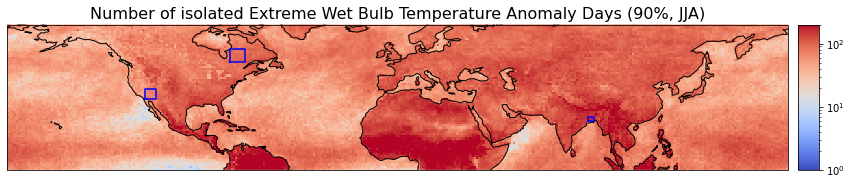

In [48]:
#length of isolated TW days map

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming precip_data_JJA, num_extreme_events_TW are already defined and valid

# Define the latitude and longitude ranges for the plot
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))

# Create the figure and axis with the appropriate projection
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-180, 180, 0, 67]
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))

# Use LogNorm for a logarithmic color scale
norm = mcolors.LogNorm(vmin=1, vmax=200) # Set vmin and vmax as needed

# Create the pcolormesh plot with the logarithmic color scale
sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:, 0]], precip_data_JJA.lat.values[lats[:, 0]], num_extreme_events_TW,
                    transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm)

# Set the lat/lon limits of the inset maps
inset_extent = [87.5, 90.5, 22.5, 24.5]
inset_extent2 = [282.5, 289.5, 49.5, 55.5]
inset_extent3 = [243.5, 248.5, 32.5, 37.5]

# Add boxes around the inset map locations on the main map
x = [inset_extent[0], inset_extent[1], inset_extent[1], inset_extent[0], inset_extent[0]]
y = [inset_extent[2], inset_extent[2], inset_extent[3], inset_extent[3], inset_extent[2]]
ax.plot(x, y, color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x2 = [inset_extent2[0], inset_extent2[1], inset_extent2[1], inset_extent2[0], inset_extent2[0]]
y2 = [inset_extent2[2], inset_extent2[2], inset_extent2[3], inset_extent2[3], inset_extent2[2]]
ax.plot(x2, y2, color='blue', alpha=1.0, transform=ccrs.PlateCarree())

x3 = [inset_extent3[0], inset_extent3[1], inset_extent3[1], inset_extent3[0], inset_extent3[0]]
y3 = [inset_extent3[2], inset_extent3[2], inset_extent3[3], inset_extent3[3], inset_extent3[2]]
ax.plot(x3, y3, color='blue', alpha=1.0, transform=ccrs.PlateCarree())

# Add the colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
ax.set_title('Number of isolated Extreme Wet Bulb Temperature Anomaly Days (90%, JJA)', fontsize=16)
plt.colorbar(sc, cax=cax)

plt.show()

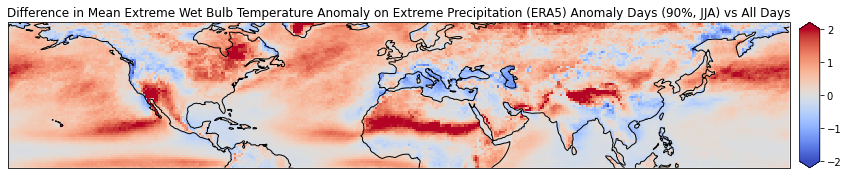

In [54]:
### wind wind contours
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))
fig= plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-180, 180, 0, 67]
#cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))

sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA,transform=ccrs.PlateCarree(), cmap='coolwarm',vmin=-2,vmax=2) #coolwarm, BrBG

#sm = plt.contourf(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, levels=np.linspace(-1, 1, 41), cmap='nipy_spectral', transform=ccrs.PlateCarree())
#wl = plt.contourf(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, levels=np.linspace(-1, 1, 21), colors='black', linewidths=2, transform=ccrs.PlateCarree())
#ax.clabel(wl, np.linspace(480, 600, 11), inline=True, fmt='%d', fontsize=14)

#sm = plt.contourf(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, 10, hatches=['..', ''], color = 'black',linestyles = 'dashed', negative_linestyles = 'dashed', alpha = 0)
#sm = plt.quiver(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, 3,  color = 'black',linestyles = 'dashed', alpha = 0)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation (ERA5) Anomaly Days (90%, JJA) vs All Days')

plt.colorbar(sc,cax=cax, extend='both') # Similar to fig.colorbar(im, cax = cax) sc, cax=cax

#ax.plot(x3, y3,color='blue', alpha=1.0, transform=ccrs.PlateCarree())
# Plot the colorbar
#cbar_ax = fig.add_axes([0, 0, 0.1, 0.1]) # Dummy values prior to finetuning the cbar position
#pos = ax.get_position() # Get the axes position
#cbar_ax.set_position([pos.x0 + pos.width + 0.01, pos.y0, 0.04, pos.height])
#cbar = plt.colorbar(wl, cax=cbar_ax)
#cbar_ax.tick_params(labelsize=16)

#plt.savefig('/RainHeatData/Figs_9_2_23/tw_3daysafter_diff_Nhem_sigmask.png')
plt.show()

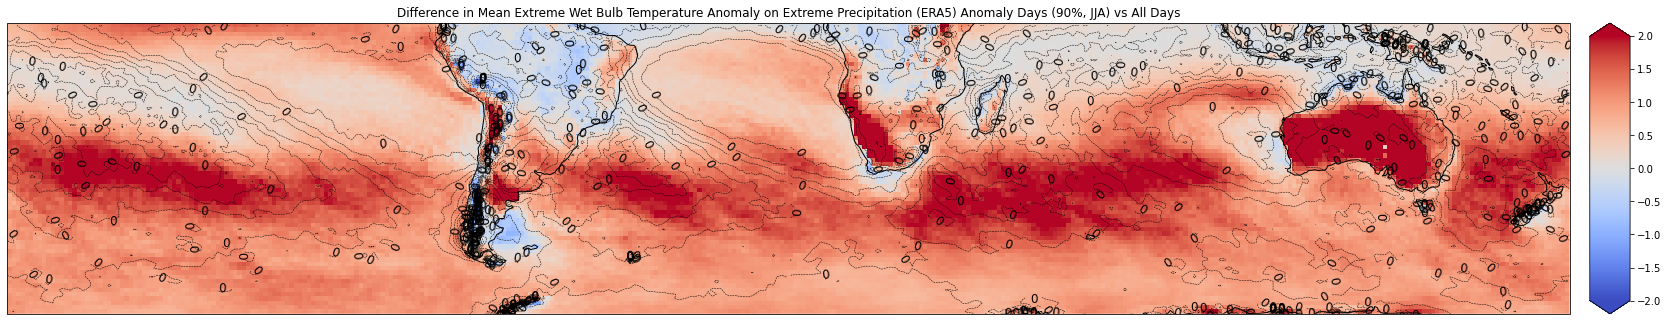

In [23]:
# Sample data for illustration

fig = plt.figure(figsize=(28, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-180, 180, -67, 0]
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))

# Plot precipitation data
sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-2, vmax=2)

# Plot wind contours
levels = np.linspace(-1, 1, 50)  # Specify levels for contour lines
wl = plt.contour(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, levels=levels, colors='black', linewidths=.5, transform=ccrs.PlateCarree())

# Add data values to contour lines
ax.clabel(wl, fmt='%d', inline=True, fontsize=12)

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
ax.set_title('Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation (ERA5) Anomaly Days (90%, JJA) vs All Days')
plt.colorbar(sc, cax=cax, extend='both')

plt.show()

## 3 regions of focus
* Region 1: Southern Arizona: 32-34N, 243-250E (try 32-38N) -- NEW COORD: 32-37N, 243-248E
* Region 2: East James Bay to US-Canada Border: 48-54N, 270-290E
* Region 2 updated: 49-55N, 282-289 N
* Region 3: Calcutta & Dhaka: 22-24N, 87-90E
* Region 4 (supplemental): Morocco:  20-30N, 0-10E

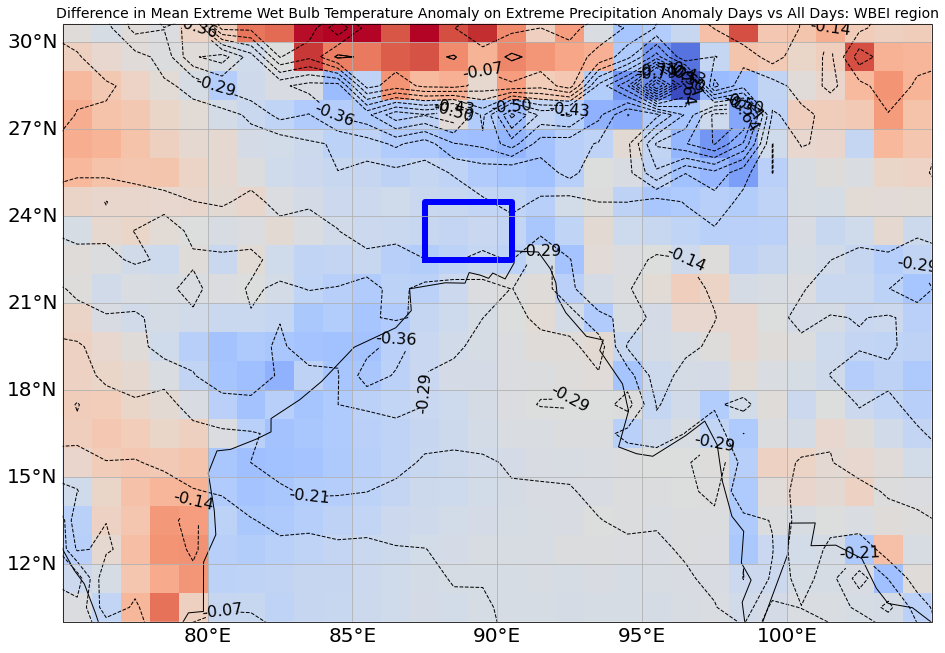

In [44]:
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))

fig = plt.figure(figsize=(24, 11))
ax = plt.axes(projection=ccrs.PlateCarree())
#extent = [-180, 180, -67, 0]
extent = [75, 105, 10, 30] #SAC region
res = '110m'
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
cm = plt.cm.get_cmap('coolwarm')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


plt.rcParams.update({'font.size': 20})

ax.set_extent(extent)

# Plot precipitation data
sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-2, vmax=2) #coolwarm -2-2, BrBG -4-4

# Plot wind contours for positive values
positive_levels = np.linspace(0, 1, 15)  # Specify levels for positive contour lines
positive_contours = plt.contour(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, levels=positive_levels,linestyles='solid', colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(positive_contours, inline=True, fmt='%1.2f', fontsize=16)

# Plot wind contours for negative values
negative_levels = np.linspace(-1, 0, 15)  # Specify levels for negative contour lines, results_JJA_wind_onTW for precip map
negative_contours = plt.contour(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], results_JJA_wind, levels=negative_levels,linestyles='dashed', colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(negative_contours, inline=True, fmt='%1.2f', fontsize=16)

# Set the lat/lon limits of the inset map [x0, x1, y0, y1]
inset_extent = [87.5, 90.5, 22.5, 24.5]
#ax.set_extent(inset_extent)

# Add box around location of inset map on the main map
x = [inset_extent[0], inset_extent[1], inset_extent[1], inset_extent[0], inset_extent[0]]
y = [inset_extent[2], inset_extent[2], inset_extent[3], inset_extent[3], inset_extent[2]]
ax.plot(x, y,color='blue', alpha=1.0, linewidth=6.0,transform=ccrs.PlateCarree())

# Add colorbar for precipitation data
#cax_precip = fig.add_axes([0.1, 0.1, 0.4, 0.02])
#plt.colorbar(sc, cax=cax_precip, orientation='vertical', label='Precipitation Anomaly')
#plt.clim(-2,2)
#plt.rc('axes', labelsize=20)
#plt.colorbar(sc ,cax=cax_precip) # Similar to fig.colorbar(im, cax = cax) sc, cax=cax
plt.clim(-2.5,2.5)
plt.rc('axes', labelsize=20)

# Add colorbar for wind values
#cax_wind = fig.add_axes([0.55, 0.1, 0.4, 0.02])
#plt.colorbar(orientation='horizontal', cax=cax_wind, extend='both', label='500 hPa Vertical Velocity Anomaly (Pa/s)')

ax.set_title('Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation Anomaly Days vs All Days: WBEI region', fontsize=14)
#Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation Anomaly Days vs All Days: WBEI region
#Difference in Mean Extreme Precipitation Anomaly on Extreme Wet Bulb Temperature Anomaly Days vs All Days: WBEI region
plt.show()